In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from sklearn.metrics import confusion_matrix
import json

from sklearn.feature_selection import SelectPercentile, VarianceThreshold, SelectFromModel, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# 1. Preprocessing
## 1.1. read the hotel features dataset and add the binary labels

In [42]:
df = pd.read_csv('/content/gdrive/MyDrive/hotel_features_dataset.csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [43]:
df.head()

,name,country,street,region,rating,reviews,amenities,rooms,types,price,official_description
0,WH Hotel,Lebanon,Lyon Street Hamra Emille Edde,NaN,4.0,"{'Excellent': 104, 'Good': 102, 'Average': 51,...","Free High Speed Internet (WiFi),Free breakfast...","Air conditioning,Fireplace,Housekeeping,Room s...","Non-smoking rooms,Suites,Family rooms,Smoking ...",NaN,NaN
1,Le Patio Boutique Hotel,Lebanon,"1144 Marfaa, Uruguay Street Solidere",NaN,4.5,"{'Excellent': 213, 'Good': 78, 'Average': 31, ...","Paid private parking nearby,Free High Speed In...","Air conditioning,Housekeeping,Room service,Saf...","Non-smoking rooms,Suites,Family rooms,Smoking ...",121.0,NaN
2,Riviera Hotel Beirut,Lebanon,"Avenue De Paris, Corniche El Manara Riad El Solh",NaN,3.5,"{'Excellent': 90, 'Good': 101, 'Average': 69, ...","Valet parking,Free High Speed Internet (WiFi),...","Air conditioning,Private balcony,Room service,...","Ocean view,Pool view,Non-smoking rooms,Suites,...",NaN,NaN
3,Le Bristol Beyrouth,Lebanon,Mme Curie Street Verdun,NaN,4.5,"{'Excellent': 219, 'Good': 79, 'Average': 25, ...","Free High Speed Internet (WiFi),Pool,Fitness C...","Air conditioning,Room service,Safe,VIP room fa...","Non-smoking rooms,Suites,Family rooms,Smoking ...",NaN,NaN
4,Golden Tulip Midtown Hotel And Suites,Lebanon,"Building Number 483, Sidani / Souraty Street M...",NaN,4.0,"{'Excellent': 147, 'Good': 86, 'Average': 32, ...","Free parking,Free High Speed Internet (WiFi),P...","Air conditioning,Room service,Safe,Kitchenette...","Non-smoking rooms,Suites,Family rooms,Smoking ...",NaN,NaN


In [51]:
wanted_columns = ['name', 'amenities', 'rooms','types','reviews']
df = df[wanted_columns]
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62719 entries, 0 to 73073
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       62719 non-null  object 
 1   amenities  62719 non-null  object 
 2   rooms      62719 non-null  object 
 3   rating     62719 non-null  float64
 4   types      62719 non-null  object 
 5   reviews    62719 non-null  object 
dtypes: float64(1), object(5)
memory usage: 3.3+ MB


In [10]:
features = df['amenities'] + ',' +df['rooms']+ ',' +df['types']

In [11]:
features_df = pd.DataFrame({'name': df.name, 'features': features})
oh_df = features_df['features'].str.get_dummies(sep=',') #one hot encoded dataframe
oh_df.head(3)

,DVDs,music for children,24-hour check-in,24-hour front desk,24-hour security,ATM on site,Additional bathroom,Adult pool,Adults only,Aerobics,Aerobics offsite,Air conditioning,Air purifier,Airport transportation,Allergy-free room,Archery,Archery offsite,BBQ facilities,Babysitting,Badminton,Baggage storage,Banquet room,Bar / lounge,Bath / shower,Bathrobes,Beach,Bicycle rental,Bicycle tours,Bicycles available,Bidet,Billiards,Blackout curtains,Board games / puzzles,Boating,Body wrap,Books,Bottled water,Bowling,Bowling offsite,Breakfast available,...,hotel_amenity_smoking_rooms_available,hotel_amenity_snack_bar,hotel_amenity_snorkeling,hotel_amenity_sofa,hotel_amenity_solarium,hotel_amenity_soundproof_rooms,hotel_amenity_spa,hotel_amenity_special_diet_menus,hotel_amenity_steam_room,hotel_amenity_suites,hotel_amenity_sun_deck,hotel_amenity_sun_loungers_beach_chairs,hotel_amenity_sun_terrace,hotel_amenity_sun_umbrellas,hotel_amenity_swimming_pool_toys,hotel_amenity_swimup_bar,hotel_amenity_table_tennis,hotel_amenity_taxi_service,hotel_amenity_telephone,hotel_amenity_tennis_court,hotel_amenity_tile_marble_floor,hotel_amenity_umbrella,hotel_amenity_vending_machine,hotel_amenity_vip_room_facilities,hotel_amenity_wake_up_service_alarm_clock,hotel_amenity_walk_in_shower,hotel_amenity_walking_tours,hotel_amenity_wardrobe_closet,hotel_amenity_water_park_offsite,hotel_amenity_water_sport_equipment_rentals,hotel_amenity_waxing_services,hotel_amenity_whirlpool_bathtub,hotel_amenity_wifi,hotel_amenity_windsurfing,hotel_amenity_wine_champagne,hotel_amenity_yoga_classes,hotel_amenity_yoga_room,iPod docking station,tags_category_tag_free_airport_transportation_1,tags_category_tag_non_smoking_rooms_1
0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [54]:
labels = []
for row in df.reviews:
  parsed = json.loads(row.replace('\'', '\"'))
  denom = 0.0000001
  for key in parsed.keys():
    denom += parsed[key]
  if len(parsed)> 2:
    num = parsed['Excellent'] * 5 + parsed['Good'] * 4 + parsed['Average'] * 3 + parsed['Poor'] * 2 + parsed['Terrible'] * 1
    labels.append(num/denom)
  else: labels.append(np.nan)

In [55]:
df['label'] = [1 if x > 4.1 else 0 for x in labels]

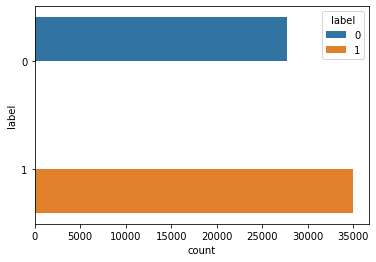

In [56]:
sns.countplot(y='label', hue='label', data=df,)

## 1.2. Splitting the data into train and test and do feature selection

In [64]:
X_train, X_test, y_train, y_test = train_test_split(oh_df, df.label, random_state=0)

In [65]:
select = SelectFromModel(
    RandomForestClassifier(n_estimators=100, random_state=42),
    threshold="mean")

select.fit(X_train, y_train)

X_train_new = select.transform(X_train)

print("X_train.shape: {}".format(X_train.shape))
print("X_train_new.shape: {}".format(X_train_new.shape))

X_test_new = select.transform(X_test)

X_train.shape: (47039, 480)
X_train_new.shape: (47039, 117)


## 1.3. visualize the new data vectors in 2D space using PCA & TNSE

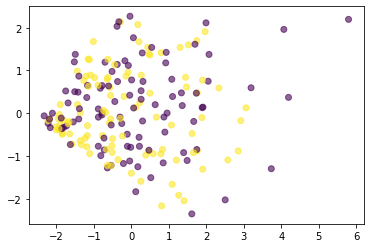

In [27]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X_train_new)
new_data = pca.transform(X_train_new)
plt.scatter(new_data[:, 0][:200], new_data[:, 1][:200], alpha=0.6, c=df.label[:200])

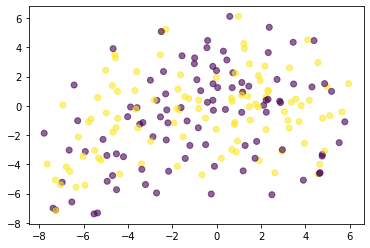

In [26]:
from sklearn.manifold import TSNE
tsne = TSNE().fit_transform(X_train_new[:200])
plt.scatter(tsne[:,0],tsne[:,1],alpha=0.6, c=df.label[:200])

# 2. Classification on binary-classes
  - **1** represents the good hotels.
  - **0** represents the bad hotels.

In [17]:
def train_and_test(model, X_train, X_test, y_train, y_test):
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  
  print(classification_report(y_test, y_pred))

  mat = confusion_matrix(y_test,y_pred)

  sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
              xticklabels=df.label.unique(), yticklabels=df.label.unique())
  plt.xlabel('true label')
  plt.ylabel('predicted label')

## 2.1. Grid Search to find the best SVM Estimator

In [16]:
from sklearn.model_selection import GridSearchCV

param_grid= {'kernel': ('linear', 'rbf','poly'),'C': [1, 10, 100]}
base_estimator = SVC(gamma='scale')
grid = GridSearchCV(base_estimator, param_grid, cv=3, scoring = 'roc_auc')

In [17]:
n_samples = 12000
grid.fit(X_train_new[:n_samples], y_train[:n_samples])

GridSearchCV(cv=3, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 10, 100],
                         'kernel': ('linear', 'rbf', 'poly')},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=0)

In [18]:
grid.best_params_

{'C': 1, 'kernel': 'rbf'}

In [19]:
model = grid.best_estimator_

              precision    recall  f1-score   support

           0       0.71      0.65      0.68      4448
           1       0.74      0.79      0.76      5552

    accuracy                           0.73     10000
   macro avg       0.73      0.72      0.72     10000
weighted avg       0.73      0.73      0.73     10000



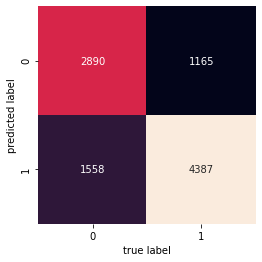

In [21]:
n_training_samples = 15000
n_testing_samples = 10000
train_and_test(model, X_train_new[:n_training_samples], X_test_new[:n_testing_samples], y_train[:n_training_samples], y_test[:n_testing_samples])

## 2.2. Grid Search to find the best Decision-Tree Classifier 

In [34]:
from sklearn.tree import DecisionTreeClassifier
tree_param = {'criterion':['gini','entropy'],'max_depth':np.arange(2,10)}
grid = GridSearchCV(DecisionTreeClassifier(), tree_param, cv=5)

In [35]:
n_samples = 30000
grid.fit(X_train_new[:n_samples], y_train[:n_samples])

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                   

In [36]:
grid.best_params_

{'criterion': 'gini', 'max_depth': 9}

In [37]:
model = grid.best_estimator_

              precision    recall  f1-score   support

           0       0.61      0.63      0.62      4448
           1       0.69      0.68      0.69      5552

    accuracy                           0.66     10000
   macro avg       0.65      0.65      0.65     10000
weighted avg       0.66      0.66      0.66     10000



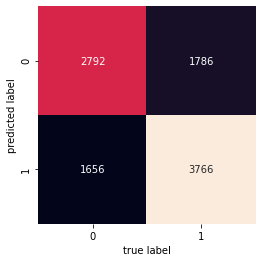

In [38]:
n_training_samples = 15000
n_testing_samples = 10000
train_and_test(model, X_train_new[:n_training_samples], X_test_new[:n_testing_samples], y_train[:n_training_samples], y_test[:n_testing_samples])

## 2.3. Logistic-Regression Classifier 

              precision    recall  f1-score   support

           0       0.69      0.63      0.66      7024
           1       0.72      0.77      0.74      8656

    accuracy                           0.71     15680
   macro avg       0.70      0.70      0.70     15680
weighted avg       0.71      0.71      0.71     15680



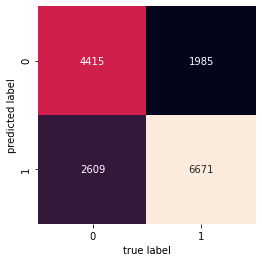

In [18]:
from sklearn.linear_model import LogisticRegression
train_and_test(LogisticRegression(), X_train_new, X_test_new, y_train, y_test)

## 2.4. Random-Forest Classifier



              precision    recall  f1-score   support

           0       0.75      0.42      0.54      7024
           1       0.65      0.88      0.75      8656

    accuracy                           0.68     15680
   macro avg       0.70      0.65      0.64     15680
weighted avg       0.69      0.68      0.66     15680



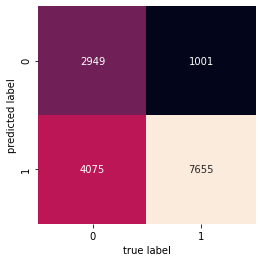

In [29]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
train_and_test(model, X_train_new, X_test_new, y_train, y_test)

## 2.5. K-Neighbors Classifier



              precision    recall  f1-score   support

           0       0.65      0.62      0.64      7024
           1       0.70      0.73      0.72      8656

    accuracy                           0.68     15680
   macro avg       0.68      0.68      0.68     15680
weighted avg       0.68      0.68      0.68     15680



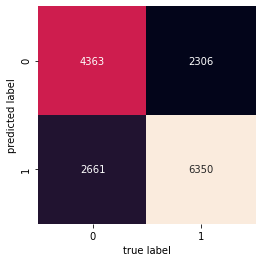

In [39]:
from sklearn.neighbors import KNeighborsClassifier
train_and_test(KNeighborsClassifier(), X_train_new, X_test_new, y_train, y_test)

# 3. Classification on Multi-class

In [60]:
bins = np.linspace(1, 5, 5)
which_bin = np.digitize(labels, bins=bins)

In [61]:
which_bin[:10]

array([3, 4, 3, 4, 4, 3, 4, 4, 4, 4])

In [62]:
df.label = which_bin

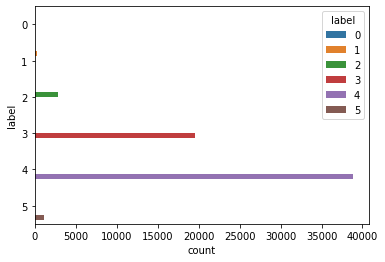

In [63]:
sns.countplot(y='label', hue='label', data=df,)

              precision    recall  f1-score   support

           0       0.67      0.10      0.17        20
           1       0.28      0.06      0.10        87
           2       0.56      0.38      0.45       701
           3       0.76      0.68      0.72      4983
           4       0.85      0.94      0.90      9611
           5       0.26      0.03      0.05       278

    accuracy                           0.81     15680
   macro avg       0.56      0.37      0.40     15680
weighted avg       0.79      0.81      0.80     15680



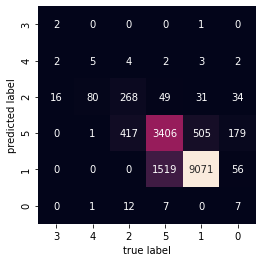

In [67]:
train_and_test(LogisticRegression(), X_train_new, X_test_new, y_train, y_test)

              precision    recall  f1-score   support

           0       0.53      0.40      0.46        20
           1       0.66      0.63      0.65        87
           2       0.59      0.62      0.61       701
           3       0.71      0.70      0.71      4983
           4       0.88      0.88      0.88      9611
           5       0.14      0.18      0.15       278

    accuracy                           0.79     15680
   macro avg       0.59      0.57      0.58     15680
weighted avg       0.80      0.79      0.80     15680



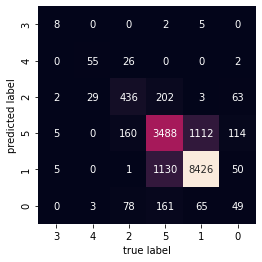

In [68]:
from sklearn.tree import DecisionTreeClassifier
train_and_test(DecisionTreeClassifier(), X_train_new, X_test_new, y_train, y_test)